In [27]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch_geometric
import torch_geometric.transforms as T
from torch_geometric.nn import HeteroConv, SAGEConv, GCNConv, Linear
from torch_geometric.loader import NeighborLoader

%matplotlib inline

This data is not code specific but code-specific graphs (CFDG etc.) can be swapped in

In [2]:
from torch_geometric.datasets import OGB_MAG

In [3]:
#see: https://ogb.stanford.edu/docs/nodeprop/#ogbn-mag
ds = OGB_MAG(root='./data', preprocess='metapath2vec')

In [4]:
print(f'Number of graphs {len(ds)}')

Number of graphs 1


In [5]:
data = ds[0]

In [6]:
data

HeteroData(
  paper={
    x=[736389, 128],
    year=[736389],
    y=[736389],
    train_mask=[736389],
    val_mask=[736389],
    test_mask=[736389]
  },
  author={ x=[1134649, 128] },
  institution={ x=[8740, 128] },
  field_of_study={ x=[59965, 128] },
  (author, affiliated_with, institution)={ edge_index=[2, 1043998] },
  (author, writes, paper)={ edge_index=[2, 7145660] },
  (paper, cites, paper)={ edge_index=[2, 5416271] },
  (paper, has_topic, field_of_study)={ edge_index=[2, 7505078] }
)

In [7]:
data.node_types

['paper', 'author', 'institution', 'field_of_study']

In [8]:
data.edge_types

[('author', 'affiliated_with', 'institution'),
 ('author', 'writes', 'paper'),
 ('paper', 'cites', 'paper'),
 ('paper', 'has_topic', 'field_of_study')]

This dataset might look like it has nothing to do with our problem. But, the goal here is to use a GNN to do node-level predictions on a heterogeneous graph.

The graph has four types of nodes:

1. papers - 736,389 distinct nodes each with 128 features (x). There are also year labels and additional y labels
2. authors - 1,134,649 distinct nodes each with 128 features (x)
3. institutions - 8,740 distinct nodes each with 128 features (x)
4. field of study - 59,965 distinct nodes each with 128 features (x)

The goal is to predict node-level features for the paper nodes.

There are several types of (directed) edges:
1. author <-> affiliated with <-> institution: This is an edge between an author node and an institution node and has edge type "affiliated with". 1,043,998 edges
2. author <-> writes <-> paper: This is an edge between an author node and a paper node with edge type "writes". 7,145,660 edges
3. paper <-> cites <-> paper: Edge between two paper nodes of type "cites". 5,416,271 edges
4. paper <-> has topic <-> field of study: Edge between paper node and field of study node of type "has_topic". 7,505,078 edges

The paper nodes have three additional attributes - train_mask, val_mask, test_mask with number of elements in each array equal to the total number of paper nodes. These are arrays of bools indicating which set each node belongs to.

In [9]:
data['paper']['x'].shape

torch.Size([736389, 128])

In [10]:
#number of true elements = total number of paper nodes i.e.
#indicating that each node belongs to one set
assert(torch.sum(data['paper']['train_mask']) 
       + torch.sum(data['paper']['val_mask']) 
       + torch.sum(data['paper']['test_mask'])
       ==data['paper']['x'].shape[0])

In [11]:
#check that each node belongs to one of train, val or test
np.any(torch.vstack([data['paper']['train_mask'], 
                     data['paper']['val_mask'], 
                     data['paper']['test_mask']]).numpy(),
      axis=0).sum()

736389

Each node type has an associated node-level feature matrix stored in 'x'

Edges are stored as edge lists as shown below:

In [12]:
#the first edge points from node 0 to node 845
#the second ednge points from node 1 to node 996
#if a graph is directed, it'll contain both 0->845 and 845->0

data[('author', 'affiliated_with', 'institution')]['edge_index']

tensor([[      0,       1,       2,  ..., 1134645, 1134647, 1134648],
        [    845,     996,    3197,  ...,    5189,    4668,    4668]])

Optionally, edges can also have edge-level features stored in data[('author', 'affiliated_with', 'institution')]['edge_attr']

We want to predict node-level quantities. They are stored in data['paper'].y (or data['paper']['y'])

In [13]:
len(data['paper'].y)

736389

Text(0.5, 1.0, 'Number of nodes with each label')

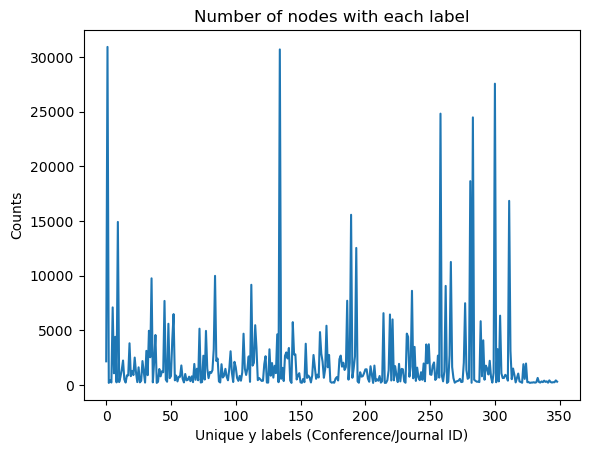

In [14]:
plt.plot(np.unique(data['paper'].y, return_counts=True)[1])
plt.xlabel('Unique y labels (Conference/Journal ID)')
plt.ylabel('Counts')
plt.title("Number of nodes with each label")
#see: https://ogb.stanford.edu/docs/nodeprop/#ogbn-mag

Since the output space is discrete i.e. we are assigning one of N labels to each node, we'll be using Multiclass log-loss as the loss function and a softmax activation. A softmax produces N probabilities that add up to 1 (normalized). In implementation, we'll use logits and a Cross entropy function that works on logits (for numerical stability).

A heterogeneous graph can be converted to a homogeneous graph (only one node type) *only* if the number of features for each node type are the same (which they are, above)

In [15]:
data.to_homogeneous()

#here all the nodes are combined into one type,
#the node-level feature matrix is concatenated along one axis,
#the edges are combined in one edge_list

Data(edge_index=[2, 21111007], x=[1939743, 128], node_type=[1939743], edge_type=[21111007])

In [16]:
#some preprocessing
data = T.ToUndirected()(data) #data can flow in all directions
data = T.AddSelfLoops()(data) #data flows from a node to itself
data = T.NormalizeFeatures()(data) #for training stability

In [17]:
#see: https://pytorch-geometric.readthedocs.io/en/latest/tutorial/heterogeneous.html

class GNN(torch.nn.Module):
    def __init__(self, metadata, num_layers, hidden_dim, out_dim):
        super().__init__()
        
        self.layer_list = torch.nn.ModuleList()
        
        for n in range(num_layers):
            #-1/(-1,-1) for input -> impute dimension
            d = {edge_type: SAGEConv((-1, -1), hidden_dim)
                 for edge_type in metadata[1]}            
            layer = HeteroConv(d, aggr='sum')
            self.layer_list.append(layer)
        
        self.output_layer = Linear(hidden_dim, out_dim)
        
    def forward(self, x_dict, edge_index_dict):
        '''Forward pass expects dictionaries of features
        and edge indices
        '''
        
        for l in self.layer_list:
            #node features are propogated based
            #on weight matrices that depend on
            #node type
            x_dict = l(x_dict, edge_index_dict)
            
            #apply activation and keep the dict structure
            x_dict = {key: x.relu() for key, x in x_dict.items()}
            
        #predicting node level quantities on papers
        out = self.output_layer(x_dict['paper'])
        
        return out

In [128]:
model = GNN(data.metadata(),
            num_layers = 3,
            hidden_dim = 64,
            out_dim = len(np.unique(data['paper']['y'])))

In [129]:
#initialize weights
with torch.no_grad():
    out = model(data.x_dict, data.edge_index_dict)

In [130]:
train_dl = NeighborLoader(
           data,
           num_neighbors = [15]*2,
           batch_size = 128,
           input_nodes=('paper', data['paper'].train_mask),
)

In [131]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
#model = model.to(device)
#data = data.to(device)

In [21]:
#model = model.to('cpu')
#data = data.to('cpu')

In [132]:
def training_loop(model,                
                  dl, 
                  data,
                  num_epochs, 
                  optimizer, 
                  print_freq=10,
                  device='cpu'):
    
    model.train()
    
    criterion = torch.nn.CrossEntropyLoss()
    
    for n in range(num_epochs):
        for batch in dl:
            optimizer.zero_grad()
            batch = batch.to(device)
            batch_size = batch['paper'].batch_size
            
            pred = model(batch.x_dict, batch.edge_index_dict)
            
            #mask = data['paper'].train_mask
            #first batch_size nodes are the original sampled nodes
            loss = criterion(pred[:batch_size], 
                             batch['paper']['y'][:batch_size].long())
        
            loss.backward()
            optimizer.step()
        
        if n % print_freq==0:
            acc_dict = val_loop(model, data, device='cpu')
            print(f'Epoch = {n} Train Loss = {acc_dict["train_mask"]} '
                  f'Val Loss = {acc_dict["val_mask"]} Test Loss = {acc_dict["test_mask"]}')
            model = model.to(device)
            
    return model, optimizer

@torch.no_grad()
def val_loop(model, data, device='cpu'):
    model.eval()
    
    '''
    pred_list, label_list = [], []
    for batch in dl:
        batch = batch.to(device)
        batch_size = batch['paper'].batch_size
        
        pred = model(batch.x_dict, batch.edge_index_dict)[:batch_size].argmax(dim=-1)
        pred_list.append(pred.detach().cpu().numpy())
        
        label = batch['paper'].y[:batch_size]
        label_list.append(label.detach().cpu().numpy())
    
    return pred_list, label_list
    '''
    
    model = model.to(device)
    data = data.to(device)
    
    pred = model(data.x_dict, data.edge_index_dict).argmax(dim=1)
    
    acc_dict = {}
    for split in ['train_mask', 'val_mask', 'test_mask']:
        mask = data['paper'][split]
        
        labels = data['paper'].y[mask]
        
        pred_split = pred[mask].float()
        
        acc = (pred_split==labels).sum() / len(labels)
        
        assert(len(labels)==mask.sum())
        
        acc_dict[split] = acc.item()
    
    return acc_dict

In [ ]:
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), 
                             lr=5e-3, 
                             weight_decay=1e-3)

model = training_loop(model, 
                      dl, 
                      data,
                      10, #num epochs
                      optimizer, 
                      print_freq=1,
                      device=device)

Epoch = 0 Train Loss = 0.002053779549896717 Val Loss = 7.706654287176207e-05 Test Loss = 0.00011922077101189643
